# Applying the Ocean function to geometries and generating grids

A common application is to test whether a certain geometry lies over the ocean and/or to generate an rasterized ocean mask.

The [natural earth collection](https://www.naturalearthdata.com) contains ocean geometries. However, naively testing for inclusion of a geometry can take a very long time since the polygon associated with Asia a has many points and is not optimized for inclusion tests. Furthermore, for most applications, the isolated Capsian Sea may also not be considered to belong to the ocean.

For these reasons a dedicated table can be generated in geoslurp, which will speed up inclusion searches and raster generation. This will be described below.

The idea is that the coastal polygons are subdivided in smaller manageable pieces with PostGIS ([ST_subdivide](https://postgis.net/docs/ST_Subdivide.html)) and a geospatial index is generated to speed up queries.

In [1]:
%load_ext autoreload
%autoreload 2

In [131]:
from geoslurp.config.catalogue import DatasetCatalogue
from geoslurp.db import Settings
from geoslurp.config import setInfoLevel

from geoslurp.db import geoslurpConnect
from geoslurp.tools.shapelytools import gdal2rastio
from geoslurp.tools.pandas import *
from geoslurp.tools.cf import *
from math import floor
import xarray as xr
import numpy as np
setInfoLevel()

gpcon=geoslurpConnect(readonly_user=False) # this will be a connection based on the readonly userfrom geoslurp.db.geo

#Some datasets need info from the server side settings so we need to load these
conf=Settings(gpcon)

#catalogue
gscat=DatasetCatalogue()

tocea="natearth.ne_10m_oceanfunc"
#original table
tocea_orig="natearth.ne_10m_ocean"



Geoslurp-INFO: Reading CF convention defaults from /home/roelof/.cf-conventions.yaml


Let's pull and register the dedicated ocean function table
```
geoslurper.py -v --pull --register "natearth.ne_10m_oceanfunc"
```

Or alternatively in Python:

In [2]:
dsoceanf=gscat.getDsetClass(conf, tocea)(gpcon)
dsoceanf.pull()
dsoceanf.register()

Geoslurp-INFO: using cached github catalogue /home/data/geoslurp_cache/githubcache/strawpants_geoshapes.yaml
Geoslurp-INFO: using cached github catalogue /home/data/geoslurp_cache/githubcache/nvkelso_natural-earth-vector.yaml
/usr/lib/python3.12/site-packages/osgeo/osr.py:410: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
Geoslurp-INFO: creating table natearth.ne_10m_oceanfunc and index, this can take a while..
Geoslurp-INFO: Done..


## Example 1: Generate a global 0.125 degree equidistant raster

Note: The generated grid can also be found on [this github repository](https://github.com/strawpants/geoshapes)

In [128]:
resolution=0.125

east=180
west=-180
south=-90
north=90
width=floor((east-west)/resolution)
height=floor((north-south)/resolution)

# create a query which creates a reference raster object and only selects those pixel longitude/lattiudes which lie within the polygons
qry=f"""
    CREATE TEMPORARY TABLE oceanrast AS 
    (SELECT ST_addband(ST_MakeEmptyRaster({width},{height},{west},{north},{resolution},-{resolution},0,0,srid=>4326),'8BUI'::text,1.0) as rast);
    SELECT ST_x(pnts.geom) as longitude ,ST_y(pnts.geom) as latitude from {tocea} as ocean INNER JOIN (SELECT (ST_PixelAsCentroids(rast, 1)).* from oceanrast ) pnts ON ST_Within(pnts.geom,ocean.geom);
"""

#load the valid lon latitudes in a pandas dataframe
dfocean=pd.DataFrame.gslrp.load(gpcon,qry)

#create an zero values grid in xaray
lat=np.arange(south+resolution/2,north,resolution)
lon=np.arange(west+resolution/2,east,resolution)

daocean=xr.DataArray(data=0.0,dims=["latitude","longitude"],coords={"longitude":("longitude",lon),"latitude":("latitude",lat)}).stack(lonlat=["longitude","latitude"])
#assign 1 at ocean points
daocean.loc[pd.MultiIndex.from_frame(dfocean)]=1.0
daocean=daocean.unstack('lonlat').T

<xarray.Dataset>
Dimensions:      (longitude: 2880, latitude: 1440)
Coordinates:
  * longitude    (longitude) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * latitude     (latitude) float64 -89.94 -89.81 -89.69 ... 89.69 89.81 89.94
    spatial_ref  int64 0
Data variables:
    oceanfunc    (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0
Attributes:
    Conventions:  CF-1.9
    title:        Gridded Ocean mask generated from natural earth 10m dataset
    institution:  Roelof Rietbroek <r.rietbroek@utwente.nl>, Faculty of Geoin...
    source:       geoslurp
    history:      2024-11-26 14:53:20.439413 geoslurp
    references:   https://geoslurp.wobbly.earth/en/latest/notebooks/OceanFunc...
    comment:      Auto generated

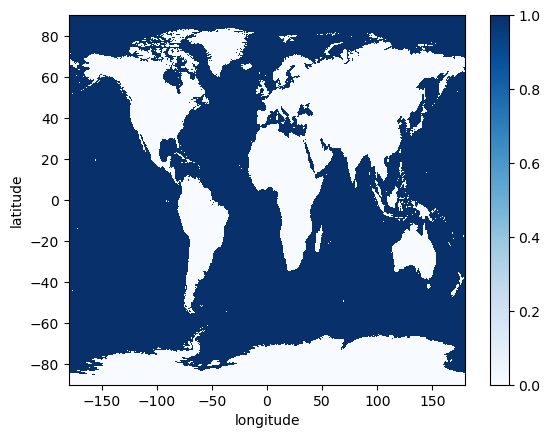

In [143]:
daocean.plot(cmap="Blues")
fout=f"/tmp/ne_10m_oceangrid_{resolution}.nc"
daocean.name='oceanfunc'
daocean=daocean.to_dataset()
cfadd_global(daocean,title="Gridded Ocean mask generated from natural earth 10m dataset",references="https://geoslurp.wobbly.earth/en/latest/notebooks/OceanFunction.html",crs=4326)
cfadd_standard_name(daocean.longitude,'longitude')
cfadd_standard_name(daocean.latitude,'latitude')

display(daocean)

daocean.to_netcdf(fout)

## Example 2: Use the optimized table for other queries

In [81]:
wkttest="Polygon ((-15.19112857609935929 54.39984018637987617, 33.96385536287604623 45.7254312559724525, 60.4001492460224938 -5.63257717326514751, -83.34719874358626157 4.00565497163198359, -15.19112857609935929 54.39984018637987617))"
from shapely import from_wkt
area=from_wkt(wkttest)
seed=1000
npoints=2000

# generate two queries

# Fast version using the index
qryfast=f"""CREATE TEMPORARY TABLE testpnts AS SELECT (ST_dump(ST_generatePoints(geom,{npoints},{seed}))).geom AS geom FROM (SELECT ST_GeomfromText('{wkttest}',4326) AS geom) AS s;
    SELECT tst.geom AS geom from testpnts AS tst INNER JOIN {tocea} as oce ON ST_within(tst.geom,oce.geom);
    """
#slow version using the original input table
qryslow=f"""CREATE TEMPORARY TABLE testpnts AS SELECT (ST_dump(ST_generatePoints(geom,{npoints},{seed}))).geom AS geom FROM (SELECT ST_GeomfromText('{wkttest}',4326) AS geom) AS s;
    SELECT tst.geom AS geom from testpnts AS tst INNER JOIN {tocea_orig} as oce ON ST_within(tst.geom,oce.geom::geometry);
    """




In [82]:
%%time
pntsslow=pd.DataFrame.gslrp.load(gpcon,qryslow)

CPU times: user 55.5 ms, sys: 3.06 ms, total: 58.6 ms
Wall time: 43.3 s


In [83]:
%%time
pntsfast=pd.DataFrame.gslrp.load(gpcon,qryfast)

CPU times: user 55.7 ms, sys: 94 μs, total: 55.8 ms
Wall time: 165 ms


# Conclusion: An indexed and subdivided geometry table speeds up the ocean queries considerably
For this particular example and database, quering 2000 points was sped up to 165 ms from 43 seconds (factor 260x)

Let's visualize the results:

(-10.0, 60.0)

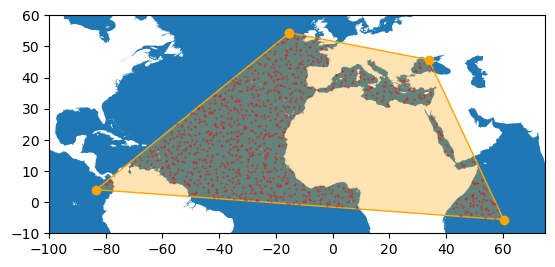

In [90]:
from shapely.plotting import plot_polygon
qry=f"SELECT geom as geom FROM {tocea_orig};"
#load the query result in a pandas dataframe
dfoce=pd.DataFrame.gslrp.load(gpcon,qry)

ax=dfoce.plot()
plot_polygon(area,ax=ax,color='orange')

pntsslow.plot(ax=ax,color='red',markersize=0.1)
ax.set_xlim([-100,75])
ax.set_ylim([-10,60])

